In [1]:
import numpy as np
import requests
import tarfile
import tensorflow as tf
import os
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def download_data():
    """
    Function to download the data
    Arguments:
    None
    Returns:
    None
    """
    url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    response = requests.get(url, stream = True)
    file = tarfile.open(fileobj=response.raw, mode="r|gz")
    file.extractall(path = '/content/drive/MyDrive/SeResNeXt Implementation/Data')
    return

# download_data()

In [4]:
def load_data():
    """
    Loads data and corresponding labels to numpy arrays and returns the image and labelled data
    Arguments:
    None
    Returns:
    1) Images reshaped into the appropriate shape
    2) Labels corresponding to the images in order
    """
    datapath = '/content/drive/MyDrive/SeResNeXt Implementation/Data/cifar-10-batches-py'
    
    # Training data:-
    training_datasets = [file for file in list(os.listdir(datapath)) if file.startswith('data_batch')]
    training_images = np.empty((0, 3, 32, 32), 'uint8')
    training_labels = np.empty((0), 'int32')
    for file in training_datasets:
        data = pickle.load(open(os.path.join(datapath, file), 'rb'), encoding = 'bytes')
        training_images = np.append(training_images, np.array(data[b'data']).reshape(-1, 3, 32,32), 0)
        training_labels = np.append(training_labels, np.array(data[b'labels']), 0)
    
    # Test data:-
    test_datasets = [file for file in list(os.listdir(datapath)) if file.startswith('test_batch')]
    test_images = np.empty((0, 3, 32, 32), 'uint8')
    test_labels = np.empty((0), 'int32')
    for file in test_datasets:
        data = pickle.load(open(os.path.join(datapath, file), 'rb'), encoding = 'bytes')
        test_images = np.append(test_images, np.array(data[b'data']).reshape(-1, 3, 32,32), 0)
        test_labels = np.append(test_labels, np.array(data[b'labels']), 0)
    
    return training_images, training_labels, test_images, test_labels

training_images, training_labels, test_images, test_labels = load_data()
label_mapping = ['airplane', 'automobile','bird','cat', 'deer', 'dog','frog', 'horse', 'ship', 'truck']

In [5]:
print(f'Number of unique pixel values in the training set:{len(np.unique(training_images.reshape((training_images.shape[0], -1))))}')
print(f'Number of unique pixel values in the test set:{len(np.unique(test_images.reshape((test_images.shape[0], -1))))}')
print(f'Number of unique labels in training set:{len(np.unique(training_labels))}\nNumber of unique labels in test set:{len(np.unique(test_labels))}')

Number of unique pixel values in the training set:256
Number of unique pixel values in the test set:256
Number of unique labels in training set:10
Number of unique labels in test set:10


In [6]:
print(f'Shape of training data: {training_images.shape}')
print(f'Shape of training labels: {training_labels.shape}')
print(f'Shape of test data: {test_images.shape}')
print(f'Shape of test labels: {test_labels.shape}')

print('-'*100)

training_images = np.swapaxes(training_images, 1,3)
test_images = np.swapaxes(test_images, 1,3)
training_images = np.swapaxes(training_images, 1,2)
test_images = np.swapaxes(test_images, 1,2)

print(f'New shape of training data: {training_images.shape}')
print(f'New shape of training labels: {training_labels.shape}')
print(f'New shape of test data: {test_images.shape}')
print(f'New shape of test labels: {test_labels.shape}')

Shape of training data: (50000, 3, 32, 32)
Shape of training labels: (50000,)
Shape of test data: (10000, 3, 32, 32)
Shape of test labels: (10000,)
----------------------------------------------------------------------------------------------------
New shape of training data: (50000, 32, 32, 3)
New shape of training labels: (50000,)
New shape of test data: (10000, 32, 32, 3)
New shape of test labels: (10000,)


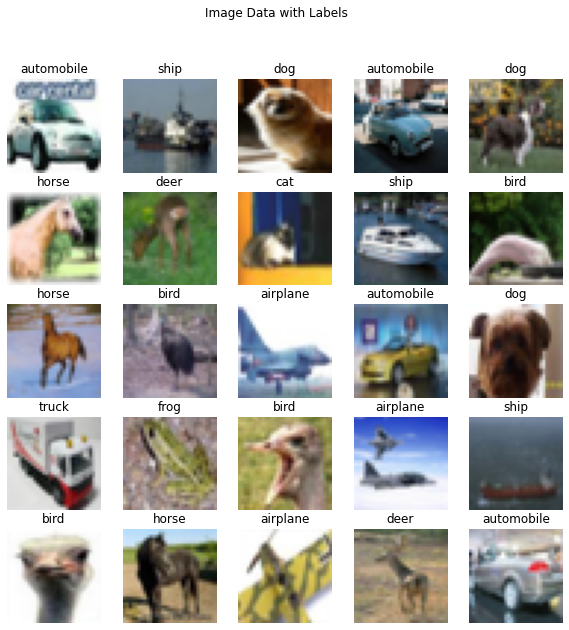

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.axis('off')
    plt.title(label_mapping[training_labels[i]])
    plt.imshow(training_images[i])
    
_ = plt.suptitle("Image Data with Labels")

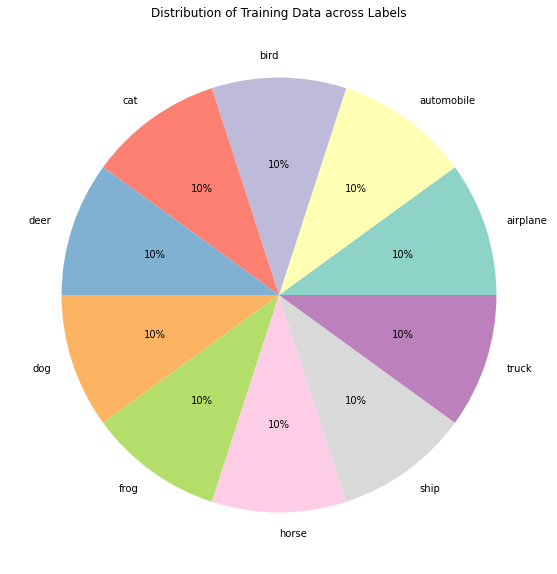

In [8]:
def count_occurences(training_labels):
    """
    """
    labels, counts = np.unique(training_labels, return_counts = True)
    return dict(zip(labels, counts))

sns.set_palette("Set3")
count_labels = count_occurences(training_labels)
plt.figure(figsize = (20,10))
plt.title("Distribution of Training Data across Labels")
plt.pie(list(count_labels.values()), labels = [label_mapping[i] for i in count_labels.keys()], autopct='%.0f%%');

In [9]:
# Conversion to tf.data.Dataset objects
one_hot_training_labels = tf.keras.utils.to_categorical(training_labels)
one_hot_test_labels = tf.keras.utils.to_categorical(test_labels)
train_ds = tf.data.Dataset.from_tensor_slices((training_images, one_hot_training_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, one_hot_test_labels))

In [10]:
train_examples = tf.data.experimental.cardinality(train_ds)
val_ds = train_ds.take(train_examples//5)
training_ds = train_ds.skip(train_examples//5)

In [11]:
BUFFER_SIZE = 100

train_dataset = training_ds.shuffle(BUFFER_SIZE)
val_dataset = val_ds.shuffle(BUFFER_SIZE)
test_dataset = test_ds.shuffle(BUFFER_SIZE)

In [12]:
def batch_and_prefetch(dataset, batch_size):
    """
    Splits input data into minibatches of specified size and prefetches it
    Arguments:
    1) Data
    2) Mini-batch size
    Returns:
    1) Dataset with mini-batches
    """
    return dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

BATCH_SIZE = 64
train_dataset = batch_and_prefetch(train_dataset, BATCH_SIZE)
val_dataset = batch_and_prefetch(val_dataset, BATCH_SIZE)
test_dataset = batch_and_prefetch(test_dataset, BATCH_SIZE)

In [13]:
batch = ()
for image_batch, label_batch in train_dataset.take(1):
    batch = image_batch

input_shape = batch[0].shape
print(input_shape)

train_dataset

(32, 32, 3)


<PrefetchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.uint8, tf.float32)>

In [14]:
def resnext_module(x, num_paths, num_channels, filter_sizes, depth):
  """
  Implements the seresnext module that will be used in the neural network
  """
  assert len(num_channels)==len(filter_sizes)
  input_channels = x.get_shape()[-1]
  inps = [x for i in range(num_paths)]
  for i in range(len(num_channels)):
    for j in range(num_paths):
      inps[j] = tf.keras.layers.Conv2D(num_channels[i], kernel_size = filter_sizes[i], padding = 'same', name = f'conv_layer_depth_{depth+1}_path_{j}_internal_{i}')(inps[j])
      inps[j] = tf.keras.layers.BatchNormalization(name = f'bn_post_conv_depth_{depth+1}_path_{j}_internal_{i}')(inps[j])
      if i != len(num_channels) - 1:
        inps[j] = tf.keras.layers.ReLU(name = f'relu_layer_post_conv_depth_{depth+1}_path_{j}_internal_{i}')(inps[j])
  
  if num_paths > 1:
    int_out = tf.keras.layers.Add(name = f'add_layer_for_multiple_paths_depth_{depth+1}')(inps)
    int_out = tf.keras.layers.ReLU(name = f'relu_layer_for_multiple_paths_depth_{depth+1}')(int_out)
  else:
    int_out = inps[0]
  if num_channels[len(num_channels) - 1] != input_channels:
    temp_x = tf.keras.layers.Conv2D(num_channels[len(num_channels) - 1], kernel_size = 1, padding = 'same', name = f'equalize_channels_depth_{depth+1}')(x)
    x = tf.keras.layers.BatchNormalization(name = f'bn_post_equalize_channels_depth_{depth+1}')(temp_x)
  out = tf.keras.layers.Add(name = f'add_layer_final_depth_{depth+1}')([int_out, x])
  out = tf.keras.layers.ReLU(name = f'resnext_module_output_layer_depth_{depth+1}')(out)
  return out

In [15]:
def resnext_model_definition(inp_shape, num_classes = 10):
  """
  Before implementation of seresnext, we should confirm that we are implementing resnext network properly
  Arguments:
  1) Input Shape
  2) Number of classes
  """
  inp = tf.keras.layers.Input(shape=inp_shape, name = 'input_layer')
  x = inp
  x = tf.keras.layers.Rescaling(scale = 1./255, name = 'rescaling_layer')(x)
  x = tf.keras.layers.Conv2D(64, kernel_size = 3, strides = (1,1), padding = 'same', name = 'conv_layer_1')(x)
  x = tf.keras.layers.BatchNormalization(name='bn_post_conv_layer_1')(x)
  x = tf.keras.layers.ReLU(name = 'relu_post_conv_layer_1')(x)
  x = tf.keras.layers.MaxPool2D(strides = (2,2), name = 'maxpool_layer_initial')(x)
  x = resnext_module(x, 1, [128, 128, 256], [1, 3, 1], 0)
  x = resnext_module(x, 1, [128, 128, 256], [1, 3, 1], 1)
  x = resnext_module(x, 1, [128, 128, 256], [1, 3, 1], 2)
  x = resnext_module(x, 1, [256, 256, 512], [1, 3, 1], 3)
  x = resnext_module(x, 1, [256, 256, 512], [1, 3, 1], 4)
  x = resnext_module(x, 1, [256, 256, 512], [1, 3, 1], 5)
  x = resnext_module(x, 1, [512, 512, 1024], [1, 3, 1], 6)
  x = resnext_module(x, 1, [512, 512, 1024], [1, 3, 1], 7)
  x = resnext_module(x, 1, [512, 512, 1024], [1, 3, 1], 8)
  x = resnext_module(x, 1, [512, 512, 1024], [1, 3, 1], 9)
  x = resnext_module(x, 1, [512, 512, 1024], [1, 3, 1], 10)
  x = resnext_module(x, 1, [512, 512, 1024], [1, 3, 1], 11)
  x = resnext_module(x, 1, [1024, 1024, 2048], [1, 3, 1], 12)
  x = resnext_module(x, 1, [1024, 1024, 2048], [1, 3, 1], 13)
  x = resnext_module(x, 1, [1024, 1024, 2048], [1, 3, 1], 14)
  x = tf.keras.layers.Conv2D(num_classes, kernel_size = 1, name = 'conv_layer_final')(x)
  x = tf.keras.layers.BatchNormalization(name='bn_post_conv_layer_final')(x)
  x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_pooling_layer')(x)
  out = tf.keras.layers.Softmax(name='classification_layer')(x)
  model = tf.keras.models.Model(inp, out)
  return model

In [16]:
resnext_model = resnext_model_definition(inp_shape = input_shape)

In [17]:
loss = tf.keras.losses.CategoricalCrossentropy()
lr = 0.1
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

resnext_model.compile(optimizer = optimizer,
                      loss = loss,metrics = ['accuracy'])

In [18]:
resnext_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_layer (Rescaling)    (None, 32, 32, 3)    0           ['input_layer[0][0]']            
                                                                                                  
 conv_layer_1 (Conv2D)          (None, 32, 32, 64)   1792        ['rescaling_layer[0][0]']        
                                                                                                  
 bn_post_conv_layer_1 (BatchNor  (None, 32, 32, 64)  256         ['conv_layer_1[0][0]']           
 malization)                                                                                  

In [19]:
tf.keras.utils.plot_model(resnext_model,show_shapes = True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Squeezenet Implementation/Training_Checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_prefix,
                                                        save_weights_only = True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=1, min_lr=1e-9)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='min', restore_best_weights=True)

EPOCHS = 20
history = resnext_model.fit(train_dataset,
                            epochs = EPOCHS,
                            callbacks = [reduce_lr,
                                         early_stop,
                                         checkpoint_callback])

Epoch 1/20
625/625 [==============================] - 1423s 2s/step - loss: 1.7338 - accuracy: 0.3341 - lr: 0.1000
Epoch 2/20
625/625 [==============================] - 1393s 2s/step - loss: 1.2164 - accuracy: 0.5569 - lr: 0.1000
Epoch 3/20
625/625 [==============================] - 1388s 2s/step - loss: 0.9916 - accuracy: 0.6463 - lr: 0.1000
Epoch 4/20
383/625 [=================>............] - ETA: 8:55 - loss: 0.8714 - accuracy: 0.6911

In [ ]:
def squeeze_and_excite_module(x, depth):
  """
  Sort of like an attention mechanism in the network to figure out which channel gets how much weightage
  Arguments:
  1) Input
  2) Depth
  """
  inp = x
  input_channels = inp.get_shape()[-1]
  squeeze_channels = input_channels/16
  x = tf.keras.layers.GlobalAveragePooling2D(keepdims = True, name = f'global_pooling_layer_squeeze_excite_{depth + 1}')(x)
  x = tf.keras.layers.Conv2D(squeeze_channels, kernel_size = 1, padding = 'same', name = f'squeeze_conv_layer_{depth+1}')(x)
  x = tf.keras.layers.ReLU(name = f'relu_post_squeeze_layer_{depth+1}')(x)
  x = tf.keras.layers.Conv2D(input_channels, kernel_size = 1, padding = 'same', name = f'expand_conv_layer_{depth+1}')(x)
  x = tf.keras.layers.Multiply(name = f'multiply_layer_{depth+1}')([inp, x])
  return x

In [ ]:
def seresnext_module(x, num_paths, num_channels, filter_sizes, depth):
  """
  Implements the seresnext module that will be used in the neural network
  """
  assert len(num_channels)==len(filter_sizes)
  input_channels = x.get_shape()[-1]
  inps = [x for i in range(num_paths)]
  for i in range(len(num_channels)):
    for j in range(num_paths):
      inps[j] = tf.keras.layers.Conv2D(num_channels[i], kernel_size = filter_sizes[i], padding = 'same', name = f'conv_layer_depth_{depth+1}_path_{j}_internal_{i}')(inps[j])
      inps[j] = tf.keras.layers.BatchNormalization(name = f'bn_post_conv_depth_{depth+1}_path_{j}_internal_{i}')(inps[j])
      if i != len(num_channels) - 1:
        inps[j] = tf.keras.layers.ReLU(name = f'relu_layer_post_conv_depth_{depth+1}_path_{j}_internal_{i}')(inps[j])
      else:
        inps[j] = squeeze_and_excite_module(inps[j], depth)
  if num_paths > 1:
    int_out = tf.keras.layers.Add(name = f'add_layer_for_multiple_paths_depth_{depth+1}')(inps)
    int_out = tf.keras.layers.ReLU(name = f'relu_layer_for_multiple_paths_depth_{depth+1}')(int_out)
  else:
    int_out = inps[0]
  if num_channels[len(num_channels) - 1] != input_channels:
    temp_x = tf.keras.layers.Conv2D(num_channels[len(num_channels) - 1], kernel_size = 1, padding = 'same', name = f'equalize_channels_depth_{depth+1}')(x)
    x = tf.keras.layers.BatchNormalization(name = f'bn_post_equalize_channels_depth_{depth+1}')(temp_x)
  out = tf.keras.layers.Add(name = f'add_layer_final_depth_{depth+1}')([int_out, x])
  out = tf.keras.layers.ReLU(name = f'seresnext_module_output_layer_depth_{depth+1}')(out)
  return out

In [ ]:
def seresnext_model_definition(inp_shape, num_classes = 10):
  """
  Before implementation of seresnext, we should confirm that we are implementing resnext network properly
  Arguments:
  1) Input Shape
  2) Number of classes
  """
  inp = tf.keras.layers.Input(shape=inp_shape, name = 'input_layer')
  x = inp
  x = tf.keras.layers.Rescaling(scale = 1./255, name = 'rescaling_layer')(x)
  x = tf.keras.layers.Conv2D(64, kernel_size = 3, strides = (1,1), padding = 'same', name = 'conv_layer_1')(x)
  x = tf.keras.layers.BatchNormalization(name='bn_post_conv_layer_1')(x)
  x = tf.keras.layers.ReLU(name = 'relu_post_conv_layer_1')(x)
  x = tf.keras.layers.MaxPool2D(strides = (2,2), name = 'maxpool_layer_initial')(x)
  x = seresnext_module(x, 1, [128, 128, 256], [1, 3, 1], 0)
  x = seresnext_module(x, 1, [128, 128, 256], [1, 3, 1], 1)
  x = seresnext_module(x, 1, [128, 128, 256], [1, 3, 1], 2)
  x = seresnext_module(x, 1, [256, 256, 512], [1, 3, 1], 3)
  x = seresnext_module(x, 1, [256, 256, 512], [1, 3, 1], 4)
  x = seresnext_module(x, 1, [256, 256, 512], [1, 3, 1], 5)
  x = seresnext_module(x, 1, [512, 512, 1024], [1, 3, 1], 6)
  x = seresnext_module(x, 1, [512, 512, 1024], [1, 3, 1], 7)
  x = seresnext_module(x, 1, [512, 512, 1024], [1, 3, 1], 8)
  x = seresnext_module(x, 1, [512, 512, 1024], [1, 3, 1], 9)
  x = seresnext_module(x, 1, [512, 512, 1024], [1, 3, 1], 10)
  x = seresnext_module(x, 1, [512, 512, 1024], [1, 3, 1], 11)
  x = seresnext_module(x, 1, [1024, 1024, 2048], [1, 3, 1], 12)
  x = seresnext_module(x, 1, [1024, 1024, 2048], [1, 3, 1], 13)
  x = seresnext_module(x, 1, [1024, 1024, 2048], [1, 3, 1], 14)
  x = tf.keras.layers.ReLU(name = 'relu_post_seresnext_module_chain')(x)
  x = tf.keras.layers.Conv2D(num_classes, kernel_size = 1, name = 'conv_layer_final')(x)
  x = tf.keras.layers.BatchNormalization(name='bn_post_conv_layer_final')(x)
  x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_pooling_layer_final')(x)
  out = tf.keras.layers.Softmax(name='classification_layer')(x)
  model = tf.keras.models.Model(inp, out)
  return model

In [ ]:
seresnext_model = seresnext_model_definition(inp_shape = input_shape)

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
lr = 0.1
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

seresnext_model.compile(optimizer = optimizer, 
                        loss = loss,metrics = ['accuracy'])

In [ ]:
seresnext_model.summary()

In [ ]:
tf.keras.utils.plot_model(seresnext_model,show_shapes = True)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Squeezenet Implementation/Training_Checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_prefix,
                                                        save_weights_only = True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=1, min_lr=1e-9)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='min', restore_best_weights=True)

EPOCHS = 20
history = seresnext_model.fit(train_dataset,
                              epochs = EPOCHS,
                              callbacks = [reduce_lr,
                                           early_stop,
                                           checkpoint_callback])